## Anomaly detection using an autoencoder

### **Note on this tutorials:**
**They mostly contain low level implementations explaining what is going on inside the library.**

**Most of the stuff explained here is already available out of the box for your usage.**

This is a utility network mainly used for debuggning

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer as optim
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json

# == recnn ==
import sys
sys.path.append("../../")
import recnn

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

cuda = torch.device('cuda')
frame_size = 10

In [2]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movies = pickle.load(open('../../data/embeddings/ml20_pca128.pkl', 'rb'))

In [3]:
for i in movies.keys():
    movies[i] = movies[i].to(cuda)

In [4]:
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()

In [7]:
data = torch.stack(list(movies.values())).to(cuda)
data = data[torch.randperm(data.size()[0])] # shuffle rows
data_test = data[-100:]
data = data[:-100]
n_epochs = 5000
batch_size = 15000

model = AnomalyDetector().to(cuda)
criterion = nn.MSELoss()
optimizer = optim.Ranger(model.parameters(), lr=1e-4, weight_decay=1e-2)
run_loss = []

In [8]:
test_loss = []
rec_loss = []
test_rec_loss = []

for epoch in tqdm(range(n_epochs)):
    for batch in data.split(batch_size):
        optimizer.zero_grad()
        batch = batch
        output = model(batch).float()
        loss = criterion(output, batch)
        test_loss.append(criterion(model(data_test).float(), data_test).item())
        rec_loss.append(model.rec_error(batch))
        test_rec_loss.append(model.rec_error(data_test))
        loss.backward()
        optimizer.step()
        run_loss.append(loss.item())

<ipython-input-8-422c8195285b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(n_epochs)):


/home/mikew/anaconda3/envs/recnn/lib/python3.8/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


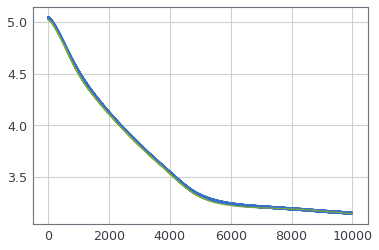

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(run_loss)
plt.plot(test_loss)
plt.show()

In [10]:
# real movies
def calc_art_score(x):
    return model.rec_error(x)  + (1 / x.var() * 5)

model.eval()
train_scores = model.rec_error(data).detach().cpu().numpy()
print(train_scores)

[224.92099 585.77966 528.3213  ... 215.87817 337.97443 397.52893]


### Now lets see what our autoencoder can do
Here you can see test scores reconstruction errors

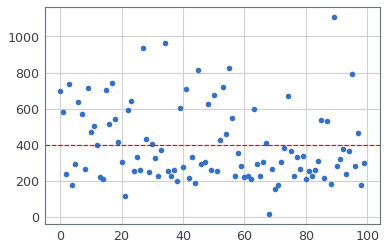

In [16]:
test_scores = model.rec_error(data_test)
scores = test_scores.detach().cpu().numpy()
plt.plot(scores, 'o')
plt.axhline(y=np.mean(scores), label='mean', linestyle='--', color='red')
plt.show()

In [17]:
from scipy import stats
# test from train doesn't seem to be that far off!
stats.wasserstein_distance(train_scores, scores)

22.486663584980334

### This example shows randomly generated movies 
drawn from ~ Normal(0, 0.2):

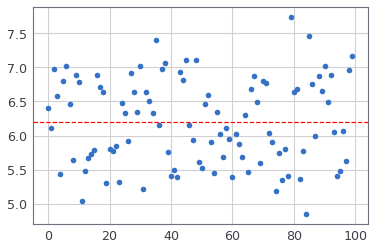

In [18]:
scores = model.rec_error(torch.tensor(np.random.normal(0, 0.2, [100, 128])).to(cuda).float())
scores = scores.detach().cpu().numpy()
plt.plot(scores, 'o')
plt.axhline(y=np.mean(scores), label='mean', linestyle='--', color='red')
plt.show()

In [19]:
stats.wasserstein_distance(train_scores, scores) # something doesnt quiet match here

399.0211505168499

### Here is that nasty -1 tensor
Normal distro was used to add some of variance

In [20]:
model.rec_error(torch.tensor([-1] * 128).unsqueeze(0).to(cuda).float())

tensor([136.6106], device='cuda:0')

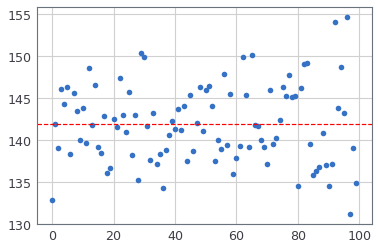

In [22]:
scores = model.rec_error(torch.tensor(np.random.normal(-1, 0.2, [100, 128])).to(cuda).float())
scores = scores.detach().cpu().numpy()
plt.plot(scores, 'o')
plt.axhline(y=np.mean(scores), label='mean', linestyle='--', color='red')
plt.show()

In [23]:
stats.wasserstein_distance(train_scores, scores) # oh oh! Look at the number at the bottom!

264.0437043496098

## As you can see it works just fine!
The key thing here is to use the WS distance as the metric and not just look at the scores.
Anyway, as in any neural networks setup, our actor will be acting in batches. We will sample the generated films batch, feed it into the autoencoder, perform MSE with the ground truth and get the reconstruction score distribution. Then we will see how closely it resembles the real one using Wasserstein-Gromov metric.
### Anyway here are some cool KDE visualizations

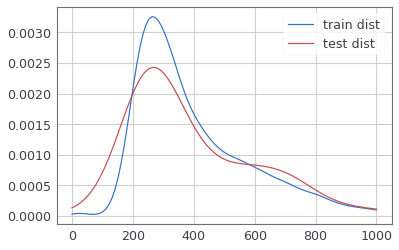

In [24]:
train_scores = model.rec_error(data).detach().cpu().numpy()
train_kernel = stats.gaussian_kde(train_scores)
test_scores = model.rec_error(data_test).detach().cpu().numpy()
test_kernel = stats.gaussian_kde(test_scores)
x = np.linspace(0,1000, 100)
probs_train = train_kernel(x)
probs_test = test_kernel(x)
plt.plot(x, probs_train, '-b', label='train dist')
plt.plot(x, probs_test, '-r', label='test dist')
plt.legend()
plt.show()

In [25]:
import pandas as pd
print(pd.Series(train_scores).describe())
print(pd.Series(test_scores).describe())

count    27178.000000
mean       405.222748
std        202.811554
min          5.092957
25%        259.896370
50%        341.583618
75%        506.556114
max       4608.396973
dtype: float64
count     100.000000
mean      396.920502
std       211.813919
min        12.653063
25%       244.549824
50%       315.021576
75%       536.957306
max      1110.174561
dtype: float64


In [26]:
torch.save(model.state_dict(), "../../models/anomaly.pt")